In [1]:

import os
import io
import shutil
import hashlib
from collections import Counter
from tqdm.auto import tqdm


import pandas as pd
import numpy as np
from PIL import Image, UnidentifiedImageError
from datasets import load_dataset


from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, RobustScaler,
    LabelEncoder, OneHotEncoder
)
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import boxcox
import joblib

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

import torch
from torch.utils.data import dataloader
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sns
import random


C:\Users\User\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print('Loading dataset from Hugging Face: ashraq/fashion-product-images-small')
ds = load_dataset('ashraq/fashion-product-images-small')
train = ds['train']
print('Rows:', train.num_rows)

Loading dataset from Hugging Face: ashraq/fashion-product-images-small
Rows: 44072


### EDA ###

In [3]:
# 1. Visualize Random Sample Images
# -----------------------
def show_random_images(df, image_col="image", label_col="masterCategory", n=9):
    samples = df.sample(n)
    fig, axes = plt.subplots(3, 3, figsize=(10,10))
    images_to_show = [] # Store image objects to prevent premature closing

    for ax, (_, row) in zip(axes.flatten(), samples.iterrows()):
        img_field = row[image_col]
        try:
            img = pil_from_image_field(img_field)
            if img is None:
                print(f"Could not open image for row {row.name}. Skipping.")
                ax.axis("off") # Hide axis for skipped image
                continue # Skip this image if it cannot be opened
            img = img.convert("RGB")
            images_to_show.append(img) # Add to list
            ax.imshow(img)
            ax.set_title(row[label_col], fontsize=10)
            ax.axis("off")
        except Exception as e:
            print(f"Error processing image for row {row.name}: {e}. Skipping.")
            ax.axis("off") # Hide axis for skipped image
            continue # Skip this image if an error occurs


    plt.suptitle("Random Sample Images", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

    # Close images after the plot is shown
    for img in images_to_show:
        try:
            img.close()
        except Exception:
            pass # Ignore errors if image is already closed or invalid



In [4]:
# Utility functions
def pil_from_image_field(image_field):
    if image_field is None:
        return None
    if isinstance(image_field, dict) and 'path' in image_field and image_field['path']:
        return Image.open(image_field['path'])
    if isinstance(image_field, (bytes, bytearray)):
        return Image.open(io.BytesIO(image_field))
    if isinstance(image_field, Image.Image):
        return image_field
    if isinstance(image_field, dict) and 'bytes' in image_field:
        return Image.open(io.BytesIO(image_field['bytes']))
    if isinstance(image_field, str) and os.path.exists(image_field):
        return Image.open(image_field)
    return None


def is_corrupt_image_field(image_field):
    try:
        img = pil_from_image_field(image_field)
        if img is None:
            return True
        img.verify()
        return False
    except Exception:
        return True


def normalized_image_hash(image_field, size=(256,256)):
    img = pil_from_image_field(image_field)
    if img is None:
        return None
    img = img.convert('RGB')
    img = img.resize(size, Image.LANCZOS)
    return hashlib.md5(img.tobytes()).hexdigest()

# 2. Check Image Quality (Blurry / Corrupted)

# Note: Corrupted images were handled in the cleaning section.
# This check is for potential issues not caught by the initial cleaning,
# or if 'image' column format changed.
def check_image_quality(df, image_col="image"):
    corrupted = []
    for idx, row in df.iterrows():
        try:
            img = pil_from_image_field(row[image_col])
            if img is None:
                corrupted.append(idx)
                continue
            img.verify()  # raises error if corrupted
            img.close() # Close image after verification
        except Exception:
            corrupted.append(idx)
    print(f"Corrupted images found: {len(corrupted)}")
    return corrupted

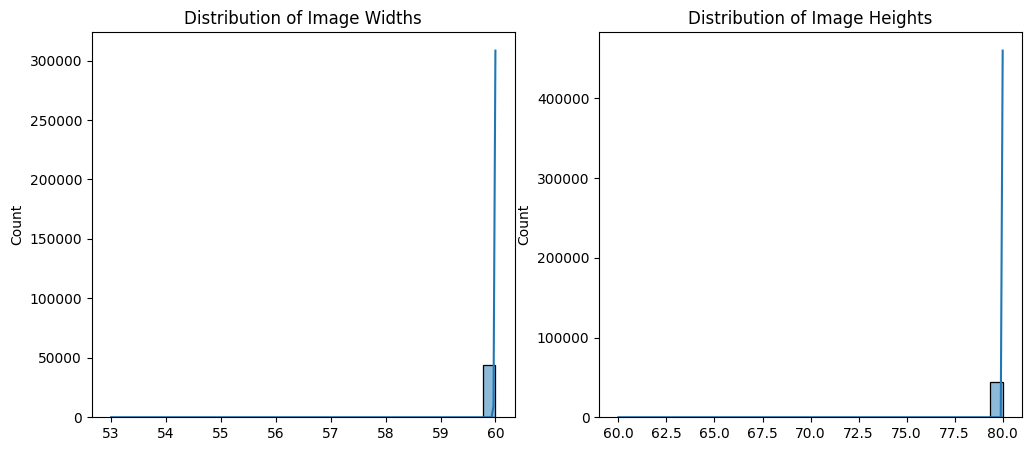

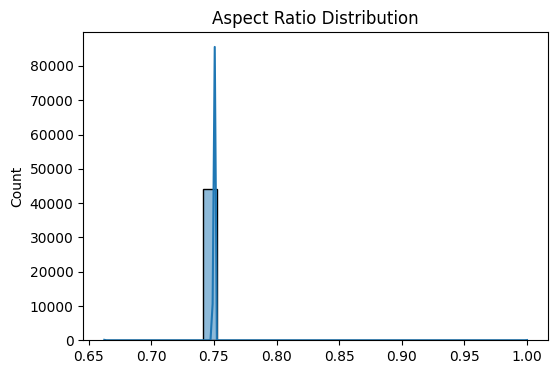

Unique color channel counts: {1, 3}


In [5]:
# 3. Check Image Properties (Sizes, Aspect Ratios, Channels)
# -----------------------
# Convert to Pandas DataFrame
meta = train.to_pandas()

sizes = []
channels = []
# Temporarily handle non-image data in 'image' column if any remain
image_rows = meta[meta['image'].apply(lambda x: isinstance(x, (Image.Image, bytes, bytearray, str, dict)) or x is None)]
for _, row in image_rows.iterrows():
    img_field = row["image"]
    try:
        pil_img = pil_from_image_field(img_field)

        if pil_img is not None:
            sizes.append(pil_img.size)  # (width, height)
            channels.append(len(pil_img.getbands()))
            pil_img.close() # Close the image file after extracting properties
        else:
            # Handle cases where pil_img is None
            sizes.append(None)
            channels.append(None)
    except Exception as e:
        # Log or print error if image cannot be processed
        print(f"Error processing image for row {row.name}: {e}")
        sizes.append(None)
        channels.append(None)


# Filter out None values before converting to NumPy array
valid_sizes = [s for s in sizes if s is not None]
valid_channels = [c for c in channels if c is not None]

sizes = np.array(valid_sizes)
# Avoid division by zero if any height is 0
aspect_ratios = sizes[:,0] / np.where(sizes[:,1] != 0, sizes[:,1], 1)


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(sizes[:,0], bins=30, kde=True) # Added kde for smoother distribution
plt.title("Distribution of Image Widths")

plt.subplot(1,2,2)
sns.histplot(sizes[:,1], bins=30, kde=True) # Added kde
plt.title("Distribution of Image Heights")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(aspect_ratios, bins=30, kde=True) # Added kde
plt.title("Aspect Ratio Distribution")
plt.show()

print("Unique color channel counts:", set(valid_channels))

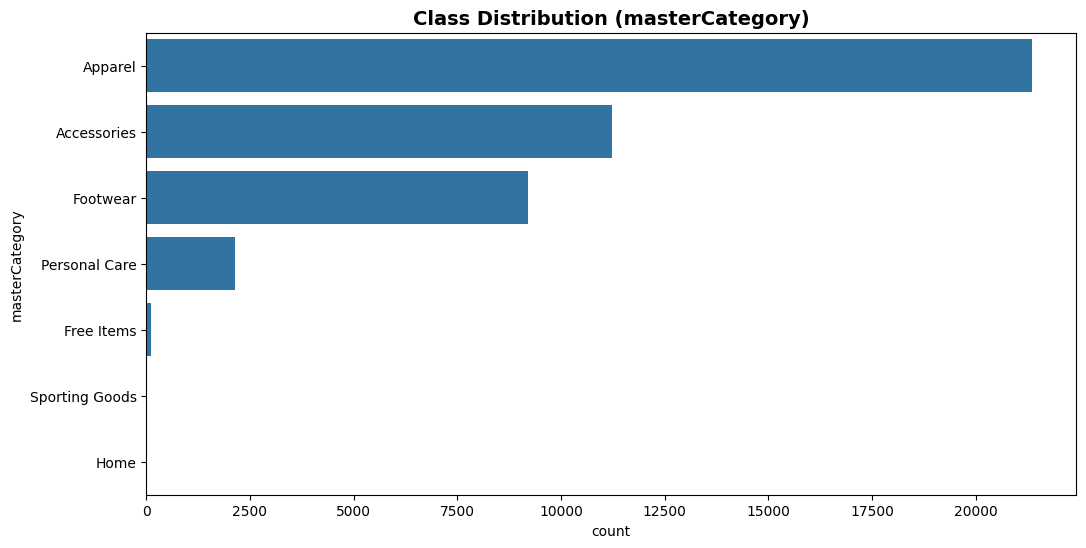

In [6]:
# 4. Visualize Class Distribution

plt.figure(figsize=(12,6))
sns.countplot(y="masterCategory", data=meta, order=meta["masterCategory"].value_counts().index)
plt.title("Class Distribution (masterCategory)", fontsize=14, fontweight="bold")
plt.show()



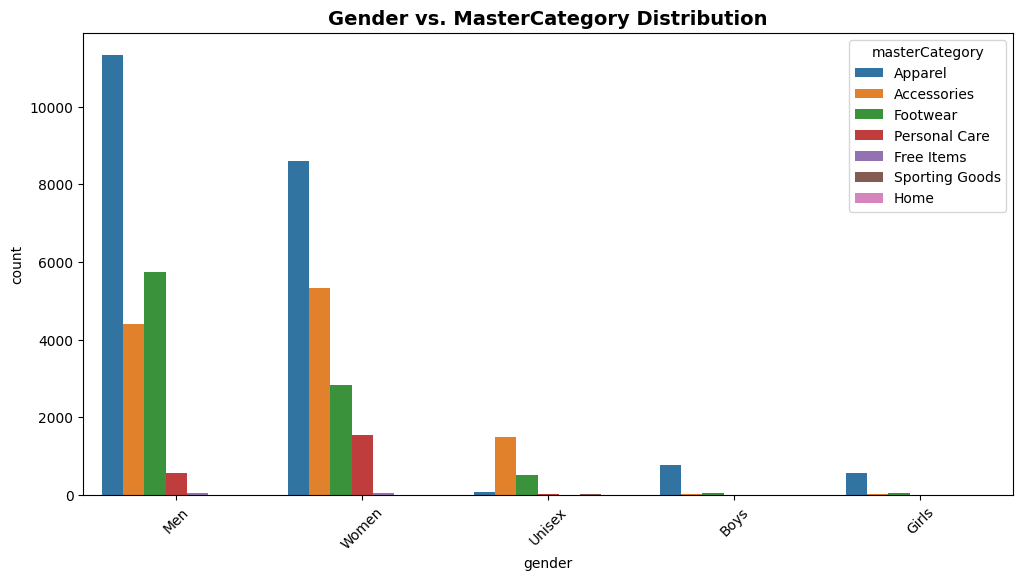

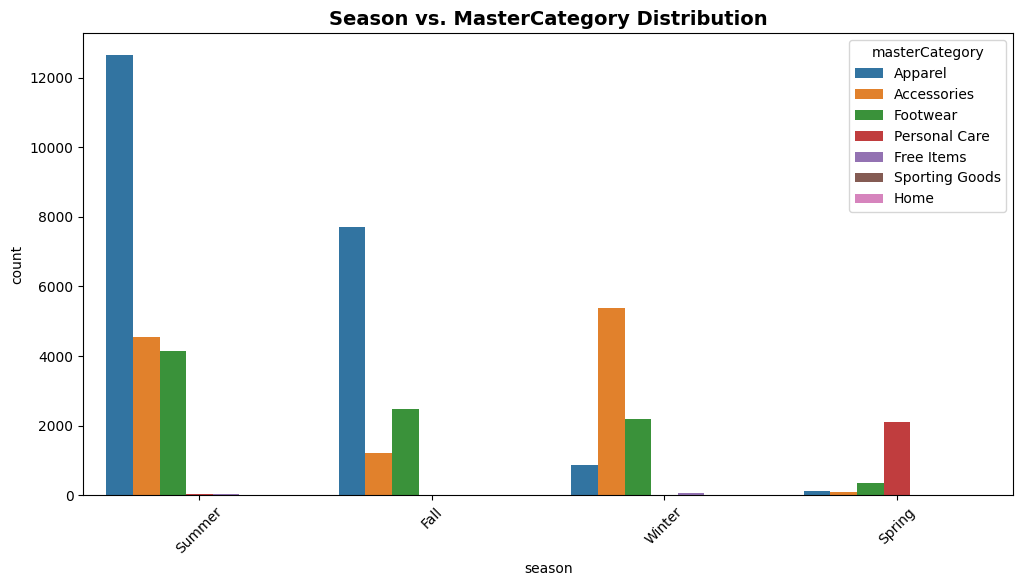

In [7]:

# 5. Investigate Data Imbalance / Bias

plt.figure(figsize=(12,6))
sns.countplot(x="gender", hue="masterCategory", data=meta, order=meta["gender"].value_counts().index)
plt.title("Gender vs. MasterCategory Distribution", fontsize=14, fontweight="bold")
plt.xticks(rotation=45) # Rotate labels for better readability
plt.show()

plt.figure(figsize=(12,6))
sns.countplot(x="season", hue="masterCategory", data=meta, order=meta["season"].value_counts().index)
plt.title("Season vs. MasterCategory Distribution", fontsize=14, fontweight="bold")
plt.xticks(rotation=45) # Rotate labels
plt.show()


### Visualization ###

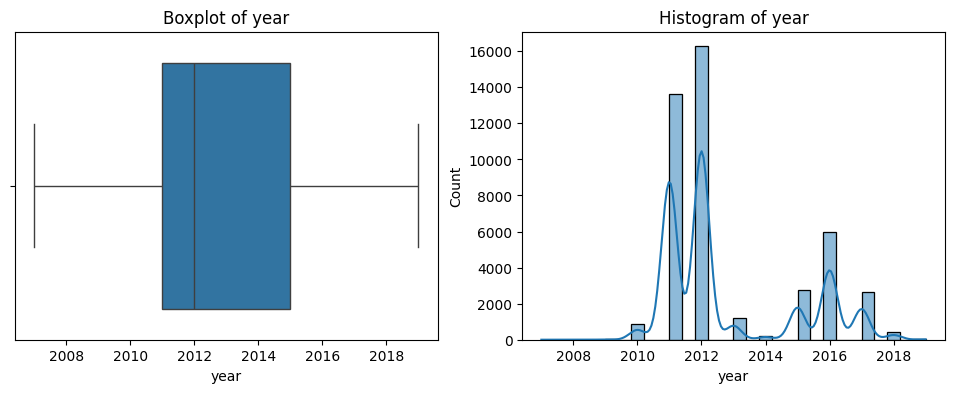

In [8]:
# (Boxplot, Histogram)
def plot_outliers(df, col):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.subplot(1,2,2)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.show()

if 'year' in meta.columns:
    plot_outliers(meta, 'year')


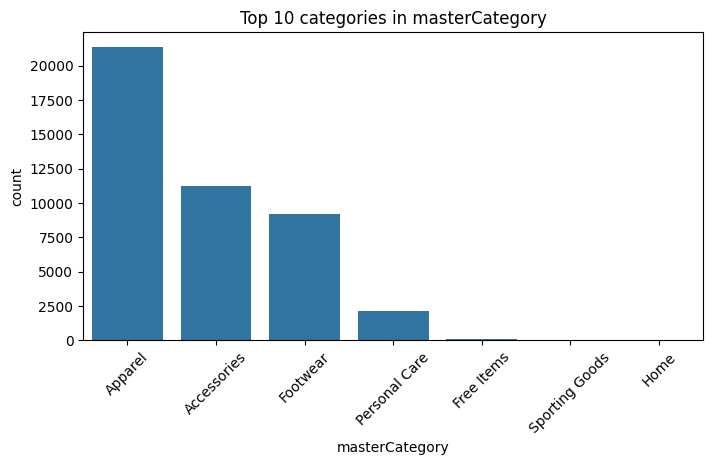

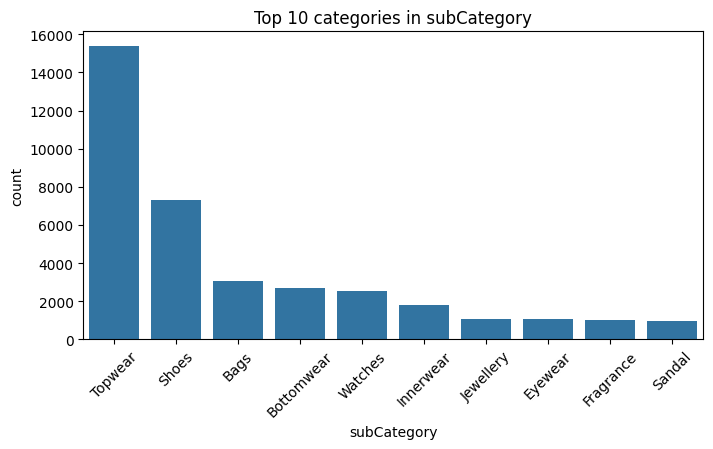

In [9]:
# Category Distributions
def plot_category_distribution(df, col, top_n=10):
    """
    Bar chart of top-N most frequent categories.
    - Shows class imbalance.
    - Helps check if rare categories should be grouped or removed.
    """
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().iloc[:top_n].index)
    plt.title(f"Top {top_n} categories in {col}")
    plt.xticks(rotation=45)
    plt.show()

plot_category_distribution(meta, 'masterCategory')
plot_category_distribution(meta, 'subCategory')

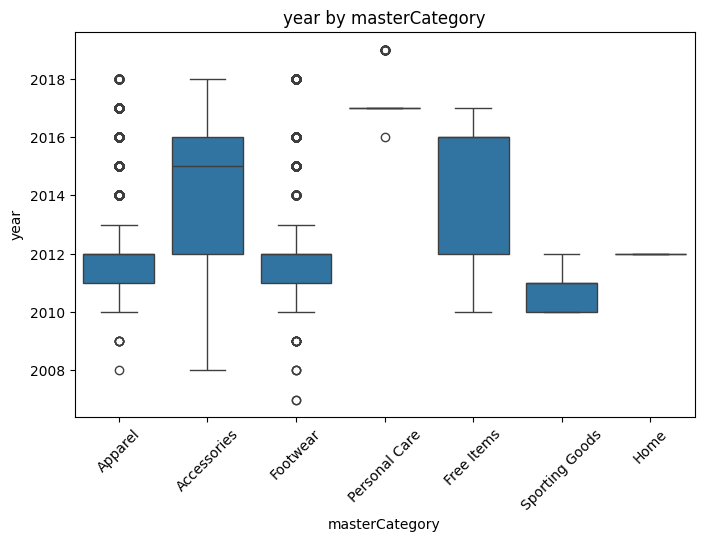

In [10]:
# Boxplots (Categorical vs Numeric)
def boxplot_cat_num(df, cat_col, num_col):
    """
    Boxplot of numeric distribution split by categories.
    - Shows median, spread, and outliers.
    - Good for comparing numeric values across groups.
    """
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x=cat_col, y=num_col)
    plt.title(f"{num_col} by {cat_col}")
    plt.xticks(rotation=45)
    plt.show()

if 'year' in meta.columns:
    boxplot_cat_num(meta, 'masterCategory', 'year')

In [11]:
# Utility functions
def pil_from_image_field(image_field):
    if image_field is None:
        return None
    if isinstance(image_field, dict) and 'path' in image_field and image_field['path']:
        return Image.open(image_field['path'])
    if isinstance(image_field, (bytes, bytearray)):
        return Image.open(io.BytesIO(image_field))
    if isinstance(image_field, Image.Image):
        return image_field
    if isinstance(image_field, dict) and 'bytes' in image_field:
        return Image.open(io.BytesIO(image_field['bytes']))
    if isinstance(image_field, str) and os.path.exists(image_field):
        return Image.open(image_field)
    return None


def is_corrupt_image_field(image_field):
    try:
        img = pil_from_image_field(image_field)
        if img is None:
            return True
        img.verify()
        return False
    except Exception:
        return True


def normalized_image_hash(image_field, size=(256,256)):
    img = pil_from_image_field(image_field)
    if img is None:
        return None
    img = img.convert('RGB')
    img = img.resize(size, Image.LANCZOS)
    return hashlib.md5(img.tobytes()).hexdigest()


### Data cleaning ###

In [12]:

# Cleaning pipeline
meta = train.to_pandas()
meta['_orig_index'] = meta.index

In [13]:
# Drop corrupt/missing images
corrupt_indices = []
for i, row in tqdm(enumerate(train), total=train.num_rows):
    if row['image'] is None or is_corrupt_image_field(row['image']):
        corrupt_indices.append(i)

print('Dropping', len(corrupt_indices), 'corrupt/missing images')
meta = meta[~meta['_orig_index'].isin(corrupt_indices)].reset_index(drop=True)


100%|██████████| 44072/44072 [00:18<00:00, 2393.31it/s]

Dropping 0 corrupt/missing images


In [14]:
#  Remove duplicates
print('Computing image hashes...')
image_hash_map = {}
for orig_i in tqdm(meta['_orig_index'].tolist()):
    row = train[orig_i]
    hsh = normalized_image_hash(row['image'])
    image_hash_map[orig_i] = hsh

meta['image_hash'] = meta['_orig_index'].map(lambda x: image_hash_map.get(x))
meta['dup_rank'] = meta.groupby('image_hash').cumcount()
meta = meta[meta['dup_rank']==0].copy().reset_index(drop=True)


Computing image hashes...


100%|██████████| 44072/44072 [01:36<00:00, 456.76it/s]


In [15]:
#  Normalize text columns
text_cols = ['gender','masterCategory','subCategory','articleType','baseColour','season','usage','productDisplayName']
for c in text_cols:
    if c in meta.columns:
        meta[c] = meta[c].fillna('').astype(str).str.strip()
        meta[c] = meta[c].replace({'': None})

for c in ['gender','masterCategory','subCategory','articleType','baseColour','season','usage']:
    if c in meta.columns:
        meta[c] = meta[c].str.lower()


In [16]:
#  Clean year column
if 'year' in meta.columns:
    meta['year'] = pd.to_numeric(meta['year'], errors='coerce')
    meta.loc[(meta['year']<1990) | (meta['year']>2030),'year'] = pd.NA
    median_year = int(meta['year'].median(skipna=True)) if not meta['year'].isna().all() else None
    if median_year:
        meta['year'] = meta['year'].fillna(median_year).astype(int)


In [17]:
# 1. Corrupt / Missing Images
def is_valid_image(image_field):
    try:
        img = pil_from_image_field(image_field)
        if img is None:
            return False
        img.verify()
        return True
    except Exception:
        return False

meta['valid_image'] = meta['image'].map(is_valid_image)
print("Invalid images:", (~meta['valid_image']).sum())
meta = meta[meta['valid_image']].drop(columns=['valid_image']).reset_index(drop=True)


Invalid images: 0


In [18]:
%pip install imagehash

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [19]:
# 2. Duplicate Images
import imagehash # Import imagehash

def compute_hash(image_field):
    img = pil_from_image_field(image_field)
    if img is None:
        return None
    try:
        # Ensure image is in a suitable mode for hashing
        img = img.convert('L') # Convert to grayscale
        return imagehash.phash(img)
    except Exception:
        return None

print('Computing image hashes...')
# Apply compute_hash to the 'image' column
# Use tqdm to show progress as this can take time
meta['img_hash'] = [compute_hash(meta['image'].iloc[i]) for i in tqdm(range(len(meta)))]

# Drop rows where image hash could not be computed
meta = meta[meta['img_hash'].notna()].reset_index(drop=True)

# Drop duplicates based on image hash
print("Initial rows:", len(meta))
meta = meta.drop_duplicates(subset=['img_hash']).reset_index(drop=True)
print("Rows after dropping duplicates:", len(meta))

meta = meta.drop(columns=['img_hash'])

Computing image hashes...


100%|██████████| 43294/43294 [00:13<00:00, 3095.28it/s]


Initial rows: 43294
Rows after dropping duplicates: 41775


In [20]:

# 3. Inconsistent Text Formats
for col in ['gender', 'masterCategory', 'subCategory', 'articleType', 'season', 'usage']:
    if col in meta.columns:
        meta[col] = meta[col].astype(str).str.lower().str.strip()

In [21]:
# 4. Missing / Invalid Years
if 'year' in meta.columns:
    meta['year'] = pd.to_numeric(meta['year'], errors='coerce')
    # Drop invalid years - using a more robust range
    meta.loc[(meta['year'] < 1950) | (meta['year'] > pd.Timestamp.now().year + 1), 'year'] = np.nan
    # Fill missing with median
    if not meta['year'].isna().all(): # Check if there are any non-NA values to compute median
        meta['year'] = meta['year'].fillna(int(meta['year'].median())).astype(int)
    else: # If all years are NA, fill with a placeholder or drop, depending on strategy
        meta['year'] = meta['year'].fillna(-1).astype(int) # Example: fill with -1

In [22]:

# 5. Low-Frequency Categories
# Drop categories with <=1 sample (causes stratified split errors)
if 'masterCategory' in meta.columns:
    cat_counts = meta['masterCategory'].value_counts()
    rare_cats = cat_counts[cat_counts <= 1].index
    print("Rare categories dropped:", len(rare_cats))
    meta = meta[~meta['masterCategory'].isin(rare_cats)].reset_index(drop=True)

Rare categories dropped: 1


In [23]:
# 6. Outlier Handling (year)
def cap_outliers(series):
    # Only cap if the series has enough data and variability
    if series.nunique() > 1 and len(series) > 10: # Basic check
        lower, upper = series.quantile(0.01), series.quantile(0.99)
        return np.clip(series, lower, upper)
    return series # Return original if not enough data/variability

if 'year' in meta.columns and meta['year'].dtype in ['int64', 'float64']: # Ensure year is numeric
    # Exclude the placeholder value if used for NA
    years_to_cap = meta[meta['year'] != -1]['year']
    if not years_to_cap.empty:
         meta.loc[meta['year'] != -1, 'year'] = cap_outliers(years_to_cap)
    print(" Outliers handled for 'year' column by capping.")


 Outliers handled for 'year' column by capping.


In [24]:
# 7. Class Imbalance → Class Weights
from sklearn.utils.class_weight import compute_class_weight # Import compute_class_weight

if 'masterCategory' in meta.columns:
    # Ensure there's more than one class and enough samples
    if meta['masterCategory'].nunique() > 1 and len(meta) > 1:
        classes = meta['masterCategory'].unique()
        # Filter out any classes that might have ended up with <= 1 sample after previous steps
        classes = [c for c in classes if meta['masterCategory'].value_counts()[c] > 1]
        if len(classes) > 1: # Re-check after filtering
            weights = compute_class_weight(class_weight="balanced", classes=np.array(classes), y=meta[meta['masterCategory'].isin(classes)]['masterCategory'])
            class_weights = dict(zip(classes, weights))
            print("Computed class weights:", class_weights)
        else:
            print("Not enough classes with > 1 sample to compute balanced class weights.")
    else:
        print("Not enough data or classes to compute balanced class weights.")

Computed class weights: {'apparel': np.float64(0.33912972885208637), 'accessories': np.float64(0.648261949099938), 'footwear': np.float64(0.8110826343584965), 'personal care': np.float64(3.8744203301799294), 'free items': np.float64(71.04421768707483), 'sporting goods': np.float64(278.49333333333334)}


In [25]:
#  Export cleaned metadata + resized RGB images
out_dir = 'cleaned_fashion_dataset'
os.makedirs(out_dir, exist_ok=True)

# Drop the 'image' column before saving to parquet
meta_to_save = meta.drop(columns=['image'], errors='ignore')
meta_to_save.to_parquet(os.path.join(out_dir, 'metadata_cleaned.parquet'), index=False)
print('Saved cleaned metadata to', os.path.join(out_dir, 'metadata_cleaned.parquet'))

images_dir = os.path.join(out_dir, 'images')
os.makedirs(images_dir, exist_ok=True)

# Recreate _orig_index column based on the current index if it was dropped
if '_orig_index' not in meta.columns:
    meta['_orig_index'] = meta.index

for _, r in tqdm(meta.iterrows(), total=len(meta)):
    orig_i = int(r['_orig_index'])
    rec = train[orig_i]
    try:
        img = pil_from_image_field(rec['image']).convert('RGB')
        img = img.resize((224,224), Image.LANCZOS)
        img.save(os.path.join(images_dir, f"{orig_i}.jpg"), format='JPEG', quality=95)
    except Exception as e:
        with open(os.path.join(out_dir, 'image_export_errors.log'), 'a') as f:
            f.write(f"{orig_i}: {e}\n")

print('Export complete: cleaned metadata + resized RGB images saved.')

Saved cleaned metadata to cleaned_fashion_dataset\metadata_cleaned.parquet


100%|██████████| 41774/41774 [01:50<00:00, 378.29it/s]

Export complete: cleaned metadata + resized RGB images saved.


### data transformation ###

In [26]:
# Convert to Pandas DataFrame
meta = pd.DataFrame(train)


In [27]:
# 2. Standardization of Formats
text_cols = ['gender','masterCategory','subCategory',
             'articleType','baseColour','season','usage','productDisplayName']
for col in text_cols:
    if col in meta.columns:
        meta[col] = meta[col].astype(str).str.lower().str.strip()


In [28]:
# 3. Scaling & Normalization (numerical features like year)
if 'year' in meta.columns:
    std_scaler = StandardScaler()
    meta['year_std'] = std_scaler.fit_transform(meta[['year']])
    joblib.dump(std_scaler, "year_std_scaler.pkl")

    meta['year_minmax'] = MinMaxScaler().fit_transform(meta[['year']])
    meta['year_robust'] = RobustScaler().fit_transform(meta[['year']])
    meta['year_log'] = np.log1p(meta['year'])

    positive_years = meta['year'] - meta['year'].min() + 1
    meta['year_boxcox'], _ = boxcox(positive_years)

In [29]:
# 4. Encoding Categorical Data
categorical_cols = ['gender','masterCategory','subCategory',
                    'articleType','baseColour','season','usage']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    meta[col + '_le'] = le.fit_transform(meta[col].astype(str))
    label_encoders[col] = le
    joblib.dump(le, f"{col}_label_encoder.pkl")

# One-hot encoding
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe_features = ohe.fit_transform(meta[['gender','season','usage']])
ohe_df = pd.DataFrame(ohe_features, columns=ohe.get_feature_names_out(['gender','season','usage']))
meta = pd.concat([meta.reset_index(drop=True), ohe_df.reset_index(drop=True)], axis=1)

# Frequency encoding (articleType)
if 'articleType' in meta.columns:
    freq_map = meta['articleType'].value_counts(normalize=True)
    meta['articleType_freq'] = meta['articleType'].map(freq_map)


In [30]:
# 5. Feature Engineering
meta['name_len'] = meta['productDisplayName'].astype(str).apply(len)
meta['word_count'] = meta['productDisplayName'].astype(str).apply(lambda x: len(x.split()))

if 'year' in meta.columns:
    meta['decade'] = (meta['year'] // 10) * 10
    meta['year_bin'] = pd.cut(meta['year'],
                              bins=[1990,2000,2010,2020,2030],
                              labels=['90s','2000s','2010s','2020s'])

meta['name_len_bin'] = pd.cut(meta['name_len'],
                              bins=[0,20,40,100],
                              labels=['short','medium','long'])


In [31]:
# 6. Dimensionality Reduction
pca = PCA(n_components=5)
meta_pca = pca.fit_transform(ohe_features)
meta_pca_df = pd.DataFrame(meta_pca, columns=[f'pca_{i}' for i in range(5)])
meta = pd.concat([meta, meta_pca_df], axis=1)


In [32]:
# 7. Handle Imbalance
class_counts = meta['masterCategory'].value_counts()
class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
print("Class Weights:", class_weights)


Class Weights: {'apparel': 4.681428772061233e-05, 'accessories': 8.893632159373888e-05, 'footwear': 0.00010873110796999022, 'personal care': 0.0004675081813931744, 'free items': 0.009523809523809525, 'sporting goods': 0.04, 'home': 1.0}


In [33]:
# 8. Handle NaN
for col in meta.columns:
    if meta[col].dtype.name == 'category':
        meta[col] = meta[col].astype(object)
meta = meta.fillna("unknown")

### Handling Outliers ###

In [34]:
# 1. Detecting Outliers (Statistical)
def detect_outliers_zscore(df, col, threshold=3):
    """Detect outliers using Z-score."""
    mean, std = df[col].mean(), df[col].std()
    z_scores = (df[col] - mean) / std
    return df[np.abs(z_scores) > threshold]

def detect_outliers_iqr(df, col):
    """Detect outliers using IQR."""
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return df[(df[col] < lower) | (df[col] > upper)]

# Example: check "year" column
if 'year' in meta.columns:
    z_outliers = detect_outliers_zscore(meta, 'year')
    iqr_outliers = detect_outliers_iqr(meta, 'year')
    print(f"Z-score outliers in year: {len(z_outliers)}")
    print(f"IQR outliers in year: {len(iqr_outliers)}")


Z-score outliers in year: 0
IQR outliers in year: 0


In [35]:
# 3. ML-based Outlier Detection
def ml_outlier_detection(df, cols):
    """Isolation Forest & LOF on selected numeric features."""
    X = df[cols].fillna(0)

    # Isolation Forest
    iso = IsolationForest(contamination=0.01, random_state=42)
    df['iso_outlier'] = iso.fit_predict(X)

    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
    df['lof_outlier'] = lof.fit_predict(X)

    return df

# Apply ML methods on numerical features
num_cols = meta.select_dtypes(include=[np.number]).columns.tolist()
meta = ml_outlier_detection(meta, num_cols)

print("Isolation Forest Outliers:", (meta['iso_outlier'] == -1).sum())
print("LOF Outliers:", (meta['lof_outlier'] == -1).sum())


Isolation Forest Outliers: 441
LOF Outliers: 441


In [36]:
# 4. Handling Outliers
def handle_outliers(df, col, method="cap"):
    if method == "remove":
        # Drop outliers
        clean_df = df[~df.index.isin(detect_outliers_iqr(df, col).index)]
    elif method == "cap":
        # Cap extreme values to 1st & 99th percentile
        lower, upper = df[col].quantile(0.01), df[col].quantile(0.99)
        clean_df = df.copy()
        clean_df[col] = np.clip(clean_df[col], lower, upper)
    elif method == "transform":
        # Apply log transformation
        clean_df = df.copy()
        clean_df[col] = np.log1p(clean_df[col] - df[col].min() + 1)
    else:
        clean_df = df  # keep as is
    return clean_df




### Splitting the Dataset ###

In [37]:
# Define the target column
target_col = 'masterCategory'

# Separate features and target
X = meta.drop(columns=[target_col])
y = meta[target_col]

# Filter out classes with only one sample before splitting
class_counts = y.value_counts()
classes_to_keep = class_counts[class_counts > 1].index
X_filtered = X[y.isin(classes_to_keep)]
y_filtered = y[y.isin(classes_to_keep)]


# First split → Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, y_filtered,
    test_size=0.3,       # 30% goes to val+test
    stratify=y_filtered, # keep class proportions
    random_state=42
)

# Split Temp into Validation (20%) and Test (10%)
# 20% of total = 2/3 of temp, 10% of total = 1/3 of temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.33,      # ~1/3rd of 30% → 10% of total
    stratify=y_temp,
    random_state=42
)

# Confirm proportions
print("Dataset sizes:")
print("Train:", len(X_train), "(", round(len(X_train)/len(meta)*100, 2), "% )")
print("Val:  ", len(X_val), "(", round(len(X_val)/len(meta)*100, 2), "% )")
print("Test: ", len(X_test), "(", round(len(X_test)/len(meta)*100, 2), "% )")

print("\nClass distribution check:")
print("Train:\n", y_train.value_counts(normalize=True))
print("Val:\n", y_val.value_counts(normalize=True))
print("Test:\n", y_test.value_counts(normalize=True))

Dataset sizes:
Train: 30849 ( 70.0 % )
Val:   8858 ( 20.1 % )
Test:  4364 ( 9.9 % )

Class distribution check:
Train:
 masterCategory
apparel           0.484683
accessories       0.255146
footwear          0.208694
personal care     0.048527
free items        0.002366
sporting goods    0.000583
Name: proportion, dtype: float64
Val:
 masterCategory
apparel           0.484760
accessories       0.255137
footwear          0.208625
personal care     0.048544
free items        0.002371
sporting goods    0.000564
Name: proportion, dtype: float64
Test:
 masterCategory
apparel           0.484647
accessories       0.255041
footwear          0.208753
personal care     0.048579
free items        0.002521
sporting goods    0.000458
Name: proportion, dtype: float64


### Data Visualization ###

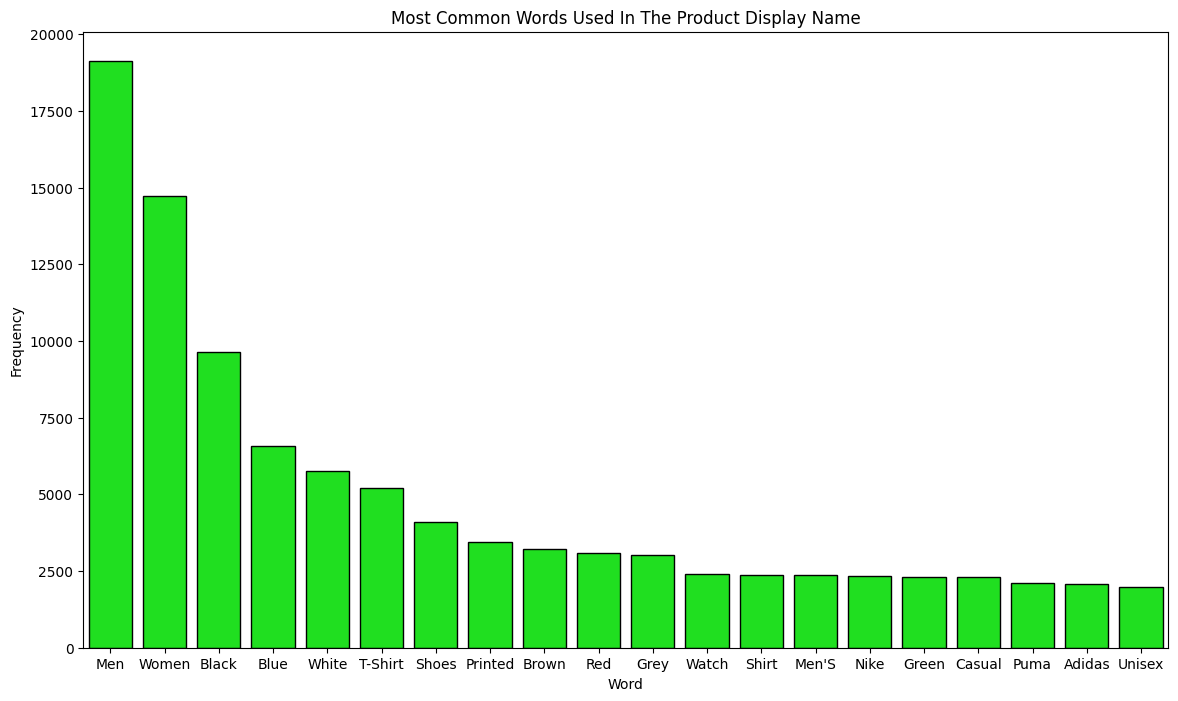

In [38]:
# first we try to visualize the most common words in the describtion column
from collections import Counter

words = " ".join(meta["productDisplayName"].astype(str).tolist()).title().split()   # make a list containing all single words
words_count = Counter(words)   # make a dict containing a each word and its apperance rate
words_count.pop("Of")  # of was one of the recurring words
words_count = words_count.most_common(20)
words_count = pd.DataFrame(words_count, columns=("Word","Frequency"))   # make it a data frame to us seaborn


plt.figure(figsize=(14,8))
sns.barplot(data=words_count, x="Word", y="Frequency", color="lime", edgecolor = "black")
plt.title("Most Common Words Used In The Product Display Name");

> insight
- the most recurring words used in Product Display Name were generic words across diffrent categories like **Men** , **Women** in *Gender* , **Black** and **Blue** in *Color* and **T-Shirt** and **Shoes** in *Product Type*

C:\Users\User\AppData\Local\Temp\ipykernel_11528\488546513.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 44072 + 1) instead
  img_index_list = np.random.random_integers(0, len(meta), size=9) # make random list of integers to display it's picstures


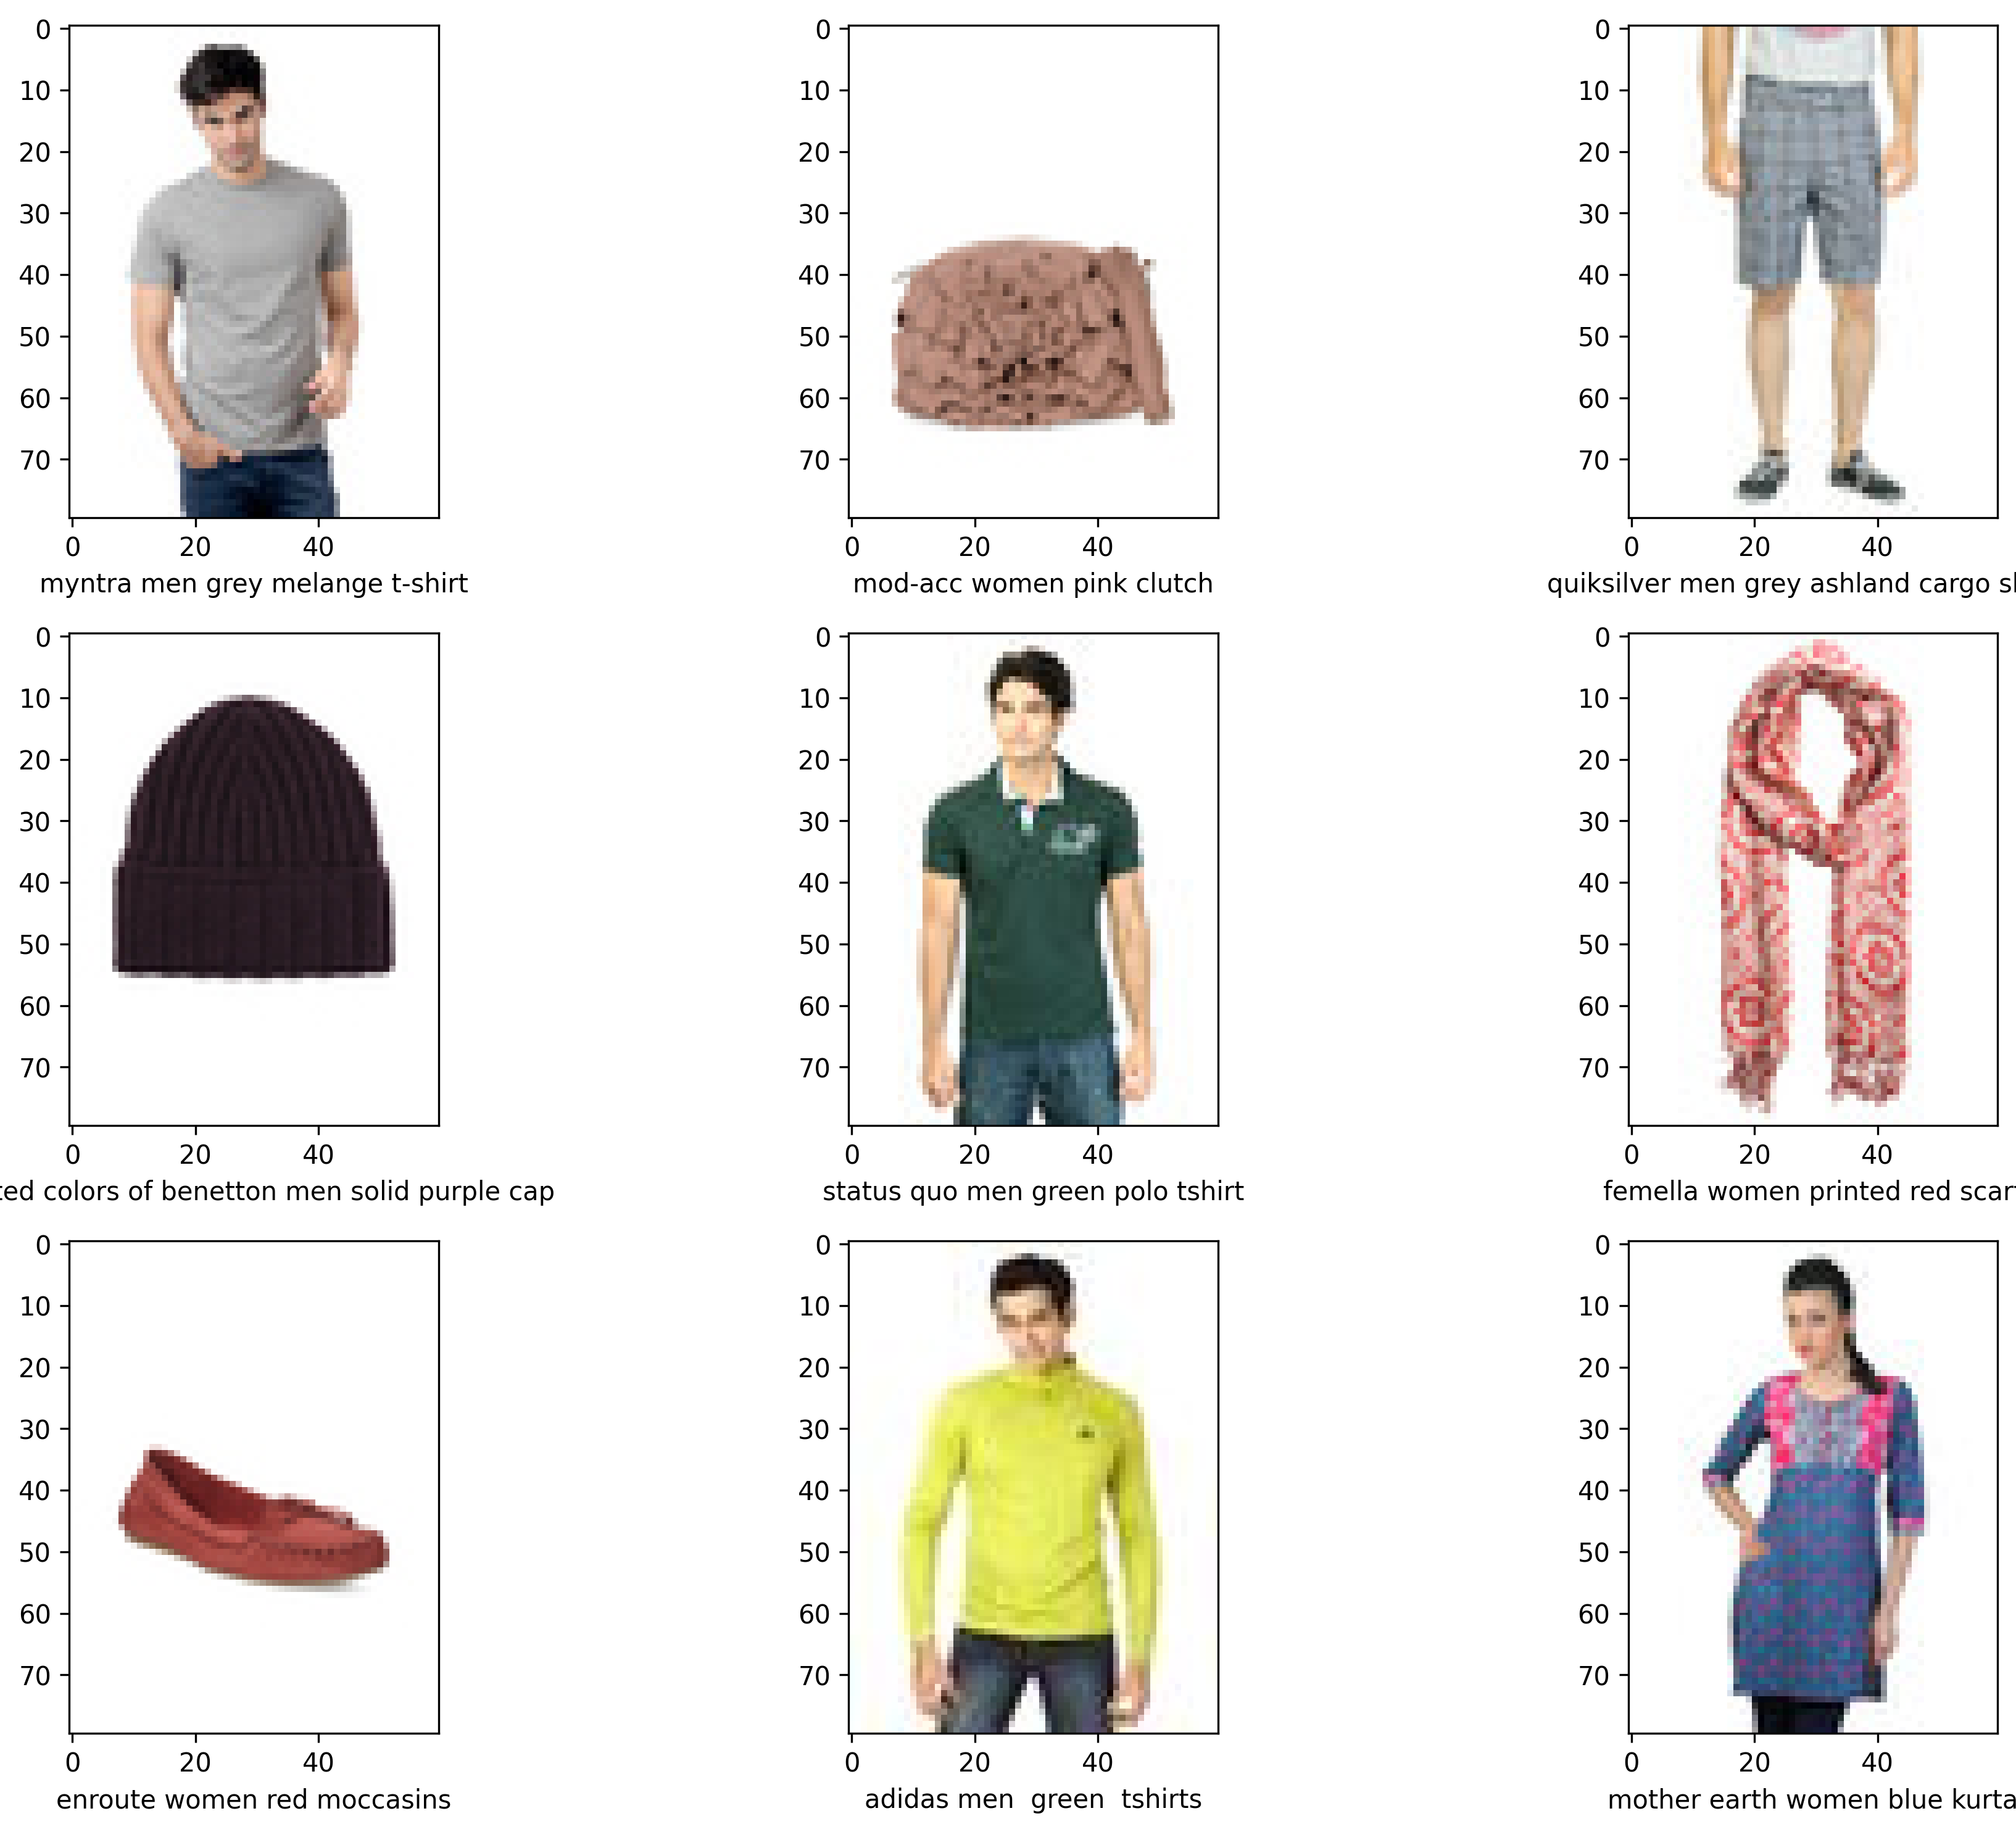

In [47]:
# to visualize the photos we will display some photos with some of its fetrues discribing it
np.random.seed(22)
img_index_list = np.random.random_integers(0, len(meta), size=9) # make random list of integers to display it's picstures
plt.figure(figsize=(14,10),dpi=300)
for i in range(9):
    plt.subplot(3,3,1 + i)
    img = meta.loc[img_index_list[i],"image",]
    plt.xlabel(f"{meta.loc[img_index_list[i],"productDisplayName"]}")
    plt.imshow(img, interpolation='none')

plt.tight_layout()


> insight 
- the data contain a varity of data to ensure diversity 

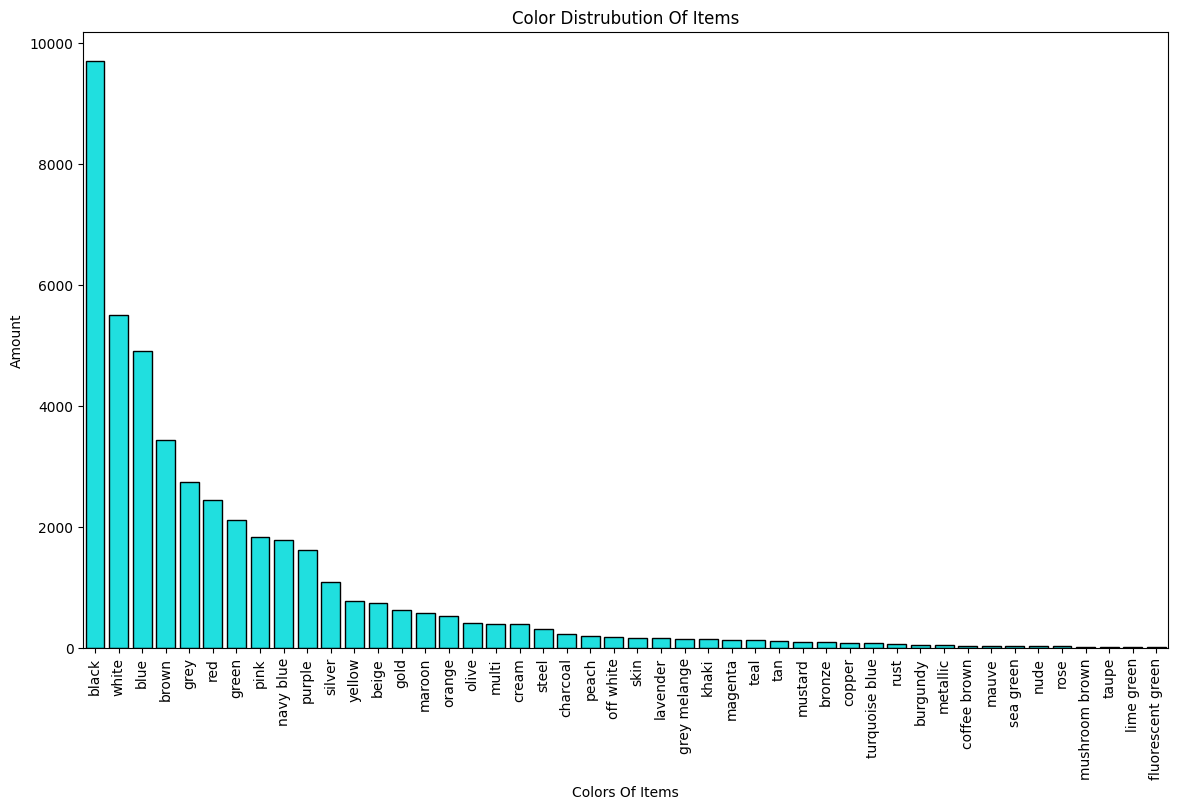

In [40]:
plt.figure(figsize=(14,8))
plt.xticks(rotation=90)
sns.countplot(data=meta, x="baseColour", order=meta["baseColour"].value_counts().index, color="cyan", edgecolor="black")
plt.title("Color Distrubution Of Items")
plt.xlabel("Colors Of Items")
plt.ylabel("Amount");

> insight
- most the of the itmes have it's color in the most frequent color seen in the the daily life like **black** and **white**
- some colors are nearly abscent like **fluorescent green**, **lime green** and **mushroom brown**

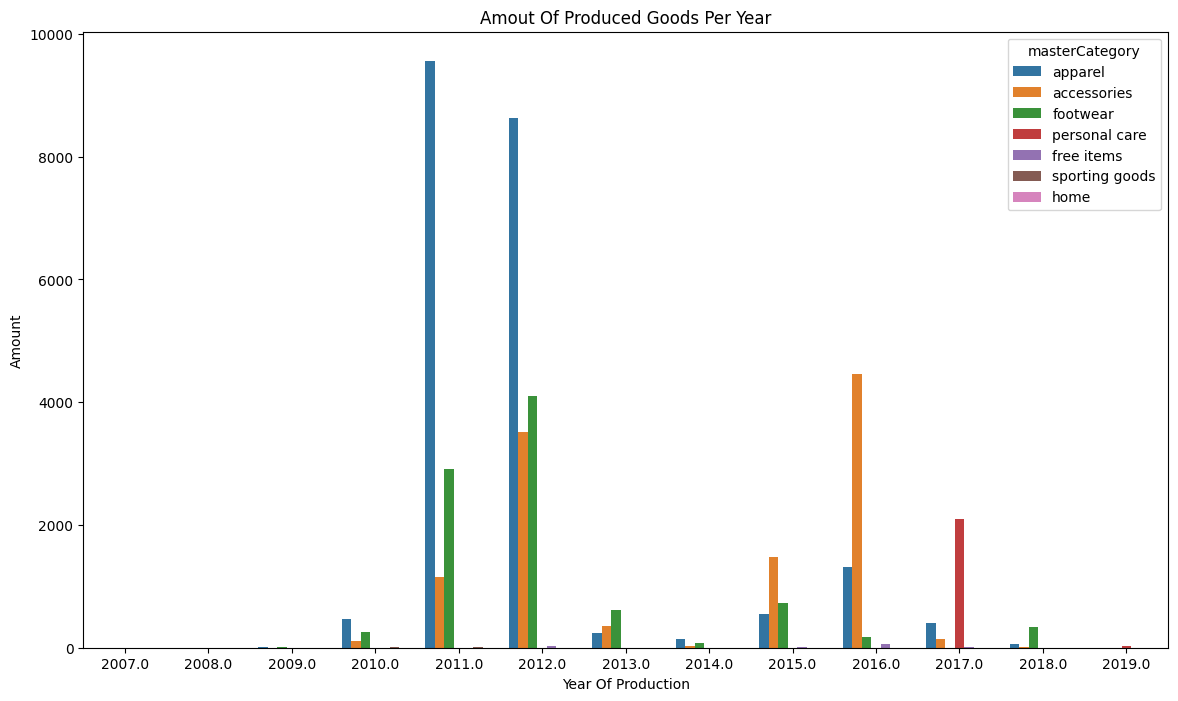

In [41]:
plt.figure(figsize=(14,8))
meta['year'] = meta['year'].astype(str)
sns.countplot(data=meta, x="year", order=sorted(meta['year'].unique()), hue="masterCategory")
plt.title("Amout Of Produced Goods Per Year")
plt.ylabel("Amount")
plt.xlabel("Year Of Production");

> insight                    
- it seems that from the years *2010* to *2012* the **apparel** master category of clothing is the leading category followed by **footwear**
- in the years *2015* and *2016* **accessories** were the most popular category
- int *2017* **personal care** product saw a huge rise in comsuption

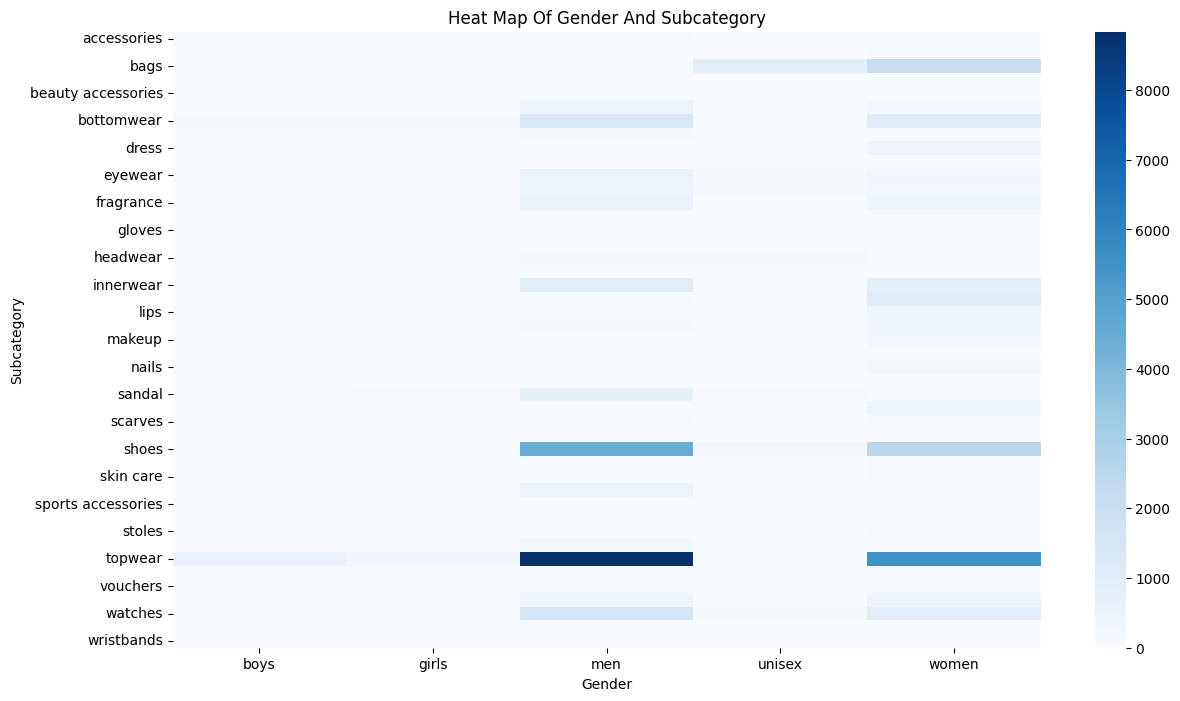

In [42]:
pivot = pd.pivot_table(meta, index="subCategory", columns="gender", aggfunc="size", fill_value=0)
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="Blues", annot=False)
plt.title("Heat Map Of Gender And Subcategory")
plt.ylabel("Subcategory")
plt.xlabel("Gender");

> insight 
- by looking at the heat map it seems that the most amount of clothing have the labels **men** **topwear** combined followed by **women** **topwear** and **men** ***shoes***
- there are very few items with **boys**,  **girls** and **unisex** labels in it which is expected due to its low demand

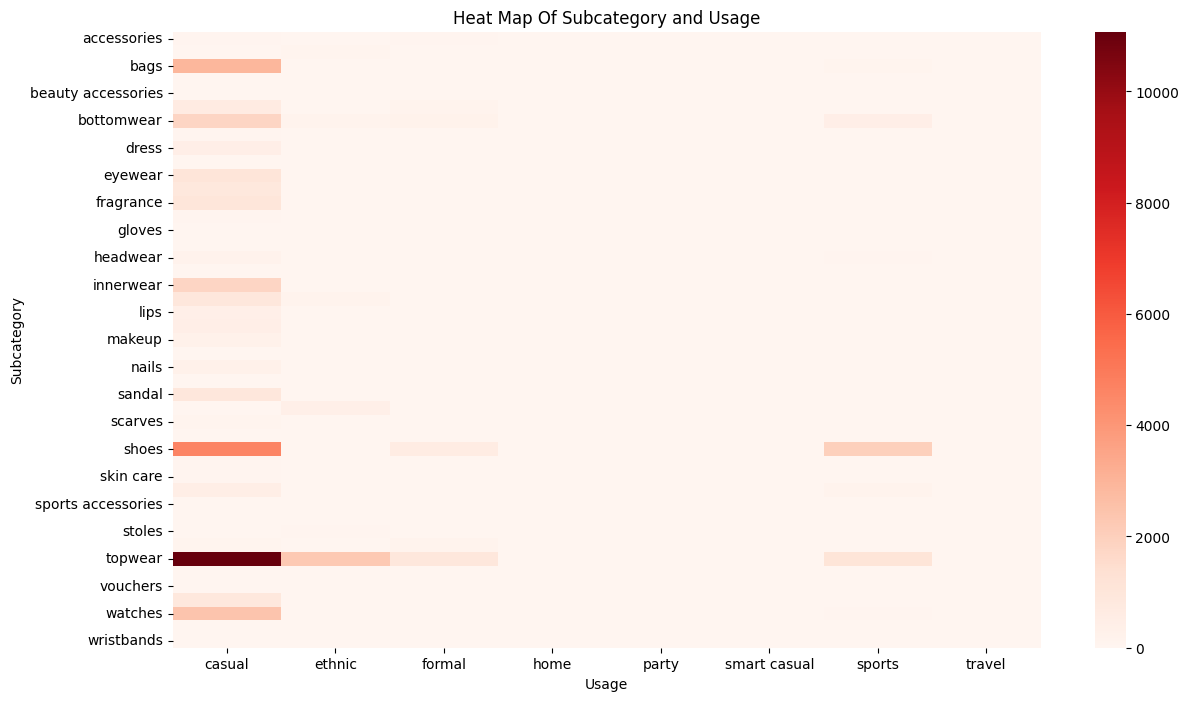

In [43]:
pivot = pd.pivot_table(meta, index="subCategory", columns="usage", aggfunc="size", fill_value=0)
plt.figure(figsize=(14,8))
sns.heatmap(pivot,cmap="Reds", annot=False)
plt.title("Heat Map Of Subcategory and Usage")
plt.ylabel("Subcategory")
plt.xlabel("Usage");

> insight
- from the heat map we can see that most item are labled casual in the usage category with topwear being the top one in the subcategory followed by shoes
- most of the usage category have little to no items in it

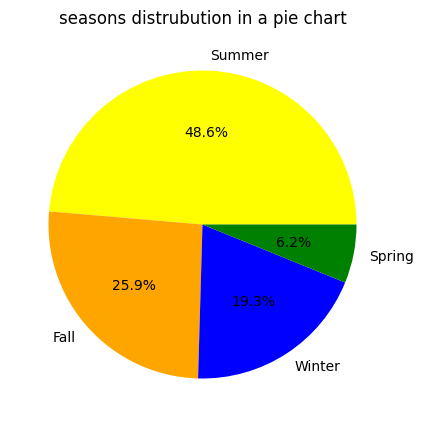

In [44]:
plt.figure(figsize=(14,5))
plt.pie(x=meta["season"].value_counts(), labels=meta["season"].value_counts().index.str.capitalize(), colors=["yellow", "orange", "blue", "green"], autopct='%1.1f%%')
plt.title("seasons distrubution in a pie chart");


### Text Embedding ###

In [45]:
# we will use all-MiniLM-L6-v2 Aka. BERT due to low data size and for more generalized results
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer("all-MiniLM-L6-v2")

In [46]:
embedding  = embedder.encode(meta["productDisplayName"])
np.save("embeddings.npy",embedding)